The CDNOW dataset is the benchmarking dataset used in the BG/NBD and other research papers. Only 10% of the full dataset is used in the research. Could the full dataset be biased?

In [1]:
import pytensor

# set flag to hotfix open c++ errors in MacOS
pytensor.config.cxx = "/usr/bin/clang++"

In [8]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from pymc_extras.prior import Prior

from pymc_marketing import clv

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Load original txt file. This was downloaded & unzipped from https://www.brucehardie.com/datasets/CDNOW_master.zip
# UPDATE: The CLV Quickstart data is a perfect simple random sample. Just use it.
# cdnow_raw = pd.read_csv(
#     "CDNOW_master/CDNOW_master.txt",
#     sep=r'\s+',
#     header=None,
#     names=['customer_id', 'date', 'quantity', 'amount']
# )
cdnow_raw = pd.read_csv(".../data/cdnow_transactions.csv")

print(f"\nDataFrame shape: {cdnow_raw.shape}")
print("\nDataFrame info:")
print(cdnow_raw.info())

print("\nFirst 10 rows:")
print(cdnow_raw.head(10))
print("\nDataFrame statistics:")
print(cdnow_raw.describe())

# convert to CSV for easy access
# cdnow_raw.to_csv("CDNOW_master.csv",index=False)


DataFrame shape: (6919, 5)

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6919 entries, 0 to 6918
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   _id         6919 non-null   int64  
 1   id          6919 non-null   int64  
 2   date        6919 non-null   int64  
 3   cds_bought  6919 non-null   int64  
 4   spent       6919 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 270.4 KB
None

First 10 rows:
   _id  id      date  cds_bought  spent
0    4   1  19970101           2  29.33
1    4   1  19970118           2  29.73
2    4   1  19970802           1  14.96
3    4   1  19971212           2  26.48
4   21   2  19970101           3  63.34
5   21   2  19970113           1  11.77
6   50   3  19970101           1   6.79
7   71   4  19970101           1  13.97
8   86   5  19970101           2  23.94
9  111   6  19970101           1  35.99

DataFrame statistics:
                _id       

In [4]:
# cdnow_full = pd.read_csv("CDNOW_master.csv")

"""
“Premium Customer”: Customers in top 2 quartiles for all variables.
“Repeat Customer”: Customers in top 2 quartiles for frequency, and either recency or monetary value.
“Top Spender”: Customers in top 2 quartiles for monetary value, and either frequency or recency.
“At-Risk Customer”: Customers in bottom 2 quartiles for two or more variables.
“Inactive Customer”: Customers in bottom quartile for two or more variables.
Customers with unspecified RFM scores will be assigned to a segment named “Other”.
"""

cdnow_segments = clv.utils.rfm_segments(
    cdnow_raw, "id", "date", "spent", datetime_format="%Y%m%d"
)
cdnow_segments.groupby("segment").count()

/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/utils.py:702: UserWarning: RFM score will not exceed 2 for f_quartile. Specify a custom segment_config
  warnings.warn(


,customer_id,frequency,recency,monetary_value,rfm_score
segment,,,,,
At Risk Customer,580,580,580,580,580
Inactive Customer,952,952,952,952,952
Other,150,150,150,150,150
Top Spender,675,675,675,675,675


In [5]:
cdnow_rfm = clv.utils.rfm_summary(
    cdnow_raw, "id", "date", "spent", datetime_format="%Y%m%d"
)
cdnow_rfm.describe()

,customer_id,frequency,recency,T,monetary_value
count,2357.000000,2357.000000,2357.000000,2357.000000,2357.000000
mean,1179.000000,1.840899,130.447179,502.011031,17.292508
std,680.551615,3.772237,176.874156,23.288656,27.358528
min,1.000000,0.000000,0.000000,462.000000,0.000000
25%,590.000000,0.000000,0.000000,482.000000,0.000000
50%,1179.000000,0.000000,0.000000,502.000000,0.000000
75%,1768.000000,2.000000,279.000000,521.000000,27.479000
max,2357.000000,43.000000,535.000000,545.000000,299.633810


It would certainly seem bias exists in the master dataset.

/var/folders/fg/0gjlwtr11dd51xt6hkb8qw6h0000gn/T/ipykernel_66668/1728552747.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


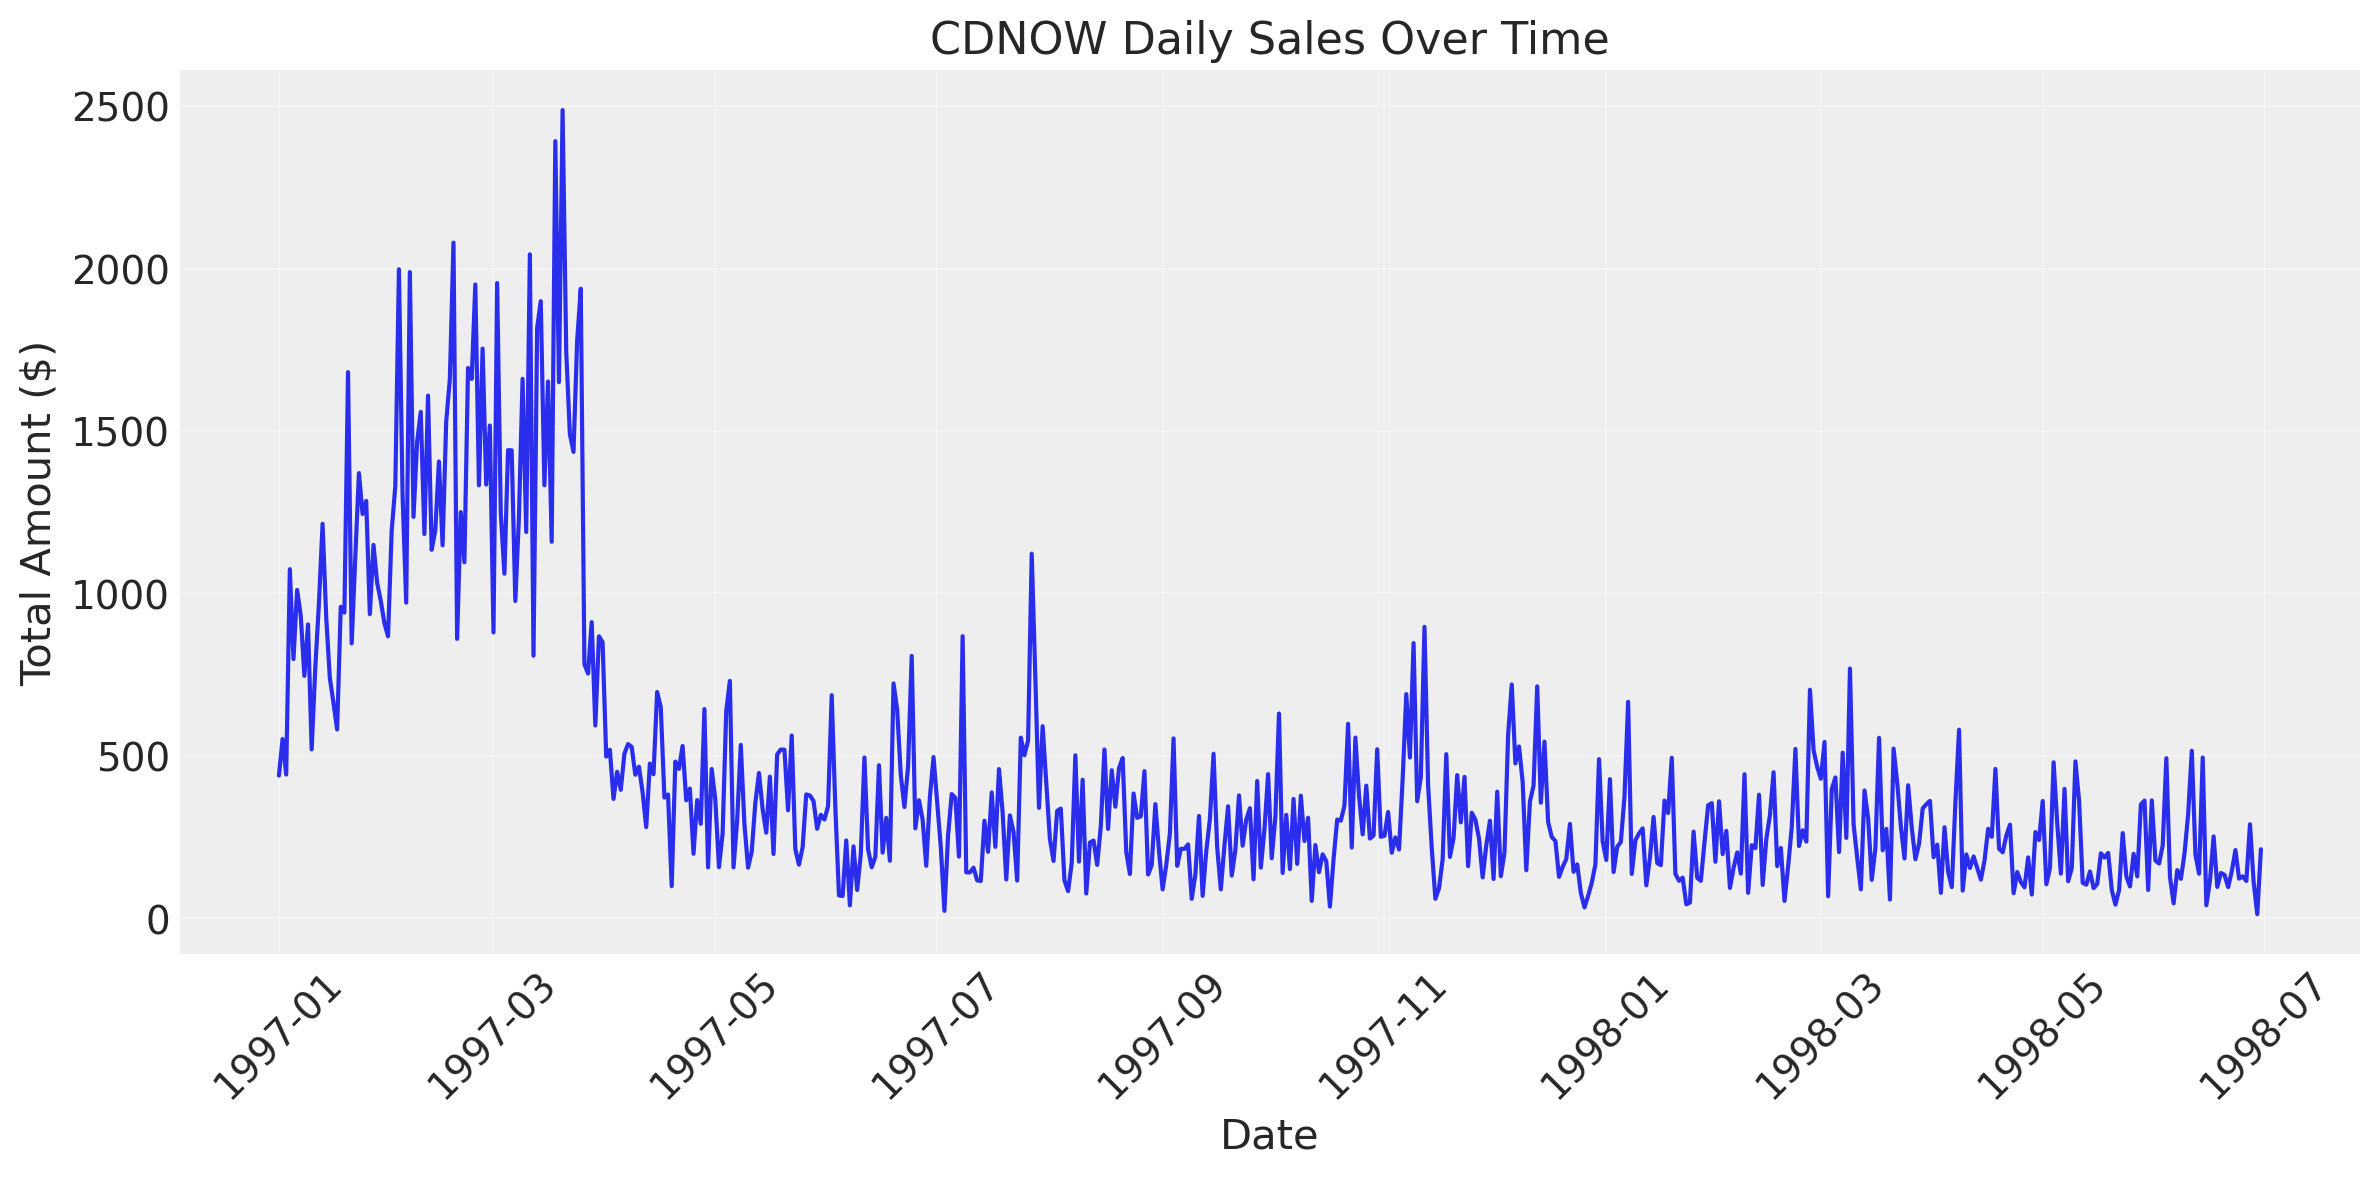

In [ ]:
# Load the data
# df = pd.read_csv('.../sandbox/cdnow_master.csv')
df = pd.read_csv(".../data/cdnow_transactions.csv")

# Convert date to datetime format
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")

# Aggregate amount by date
daily_sales = df.groupby("date")["spent"].sum().reset_index()

# Plot over time
plt.figure(figsize=(12, 6))
plt.plot(daily_sales["date"], daily_sales["spent"])
plt.xlabel("Date")
plt.ylabel("Total Amount ($)")
plt.title("CDNOW Daily Sales Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

/var/folders/fg/0gjlwtr11dd51xt6hkb8qw6h0000gn/T/ipykernel_66668/1623883832.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


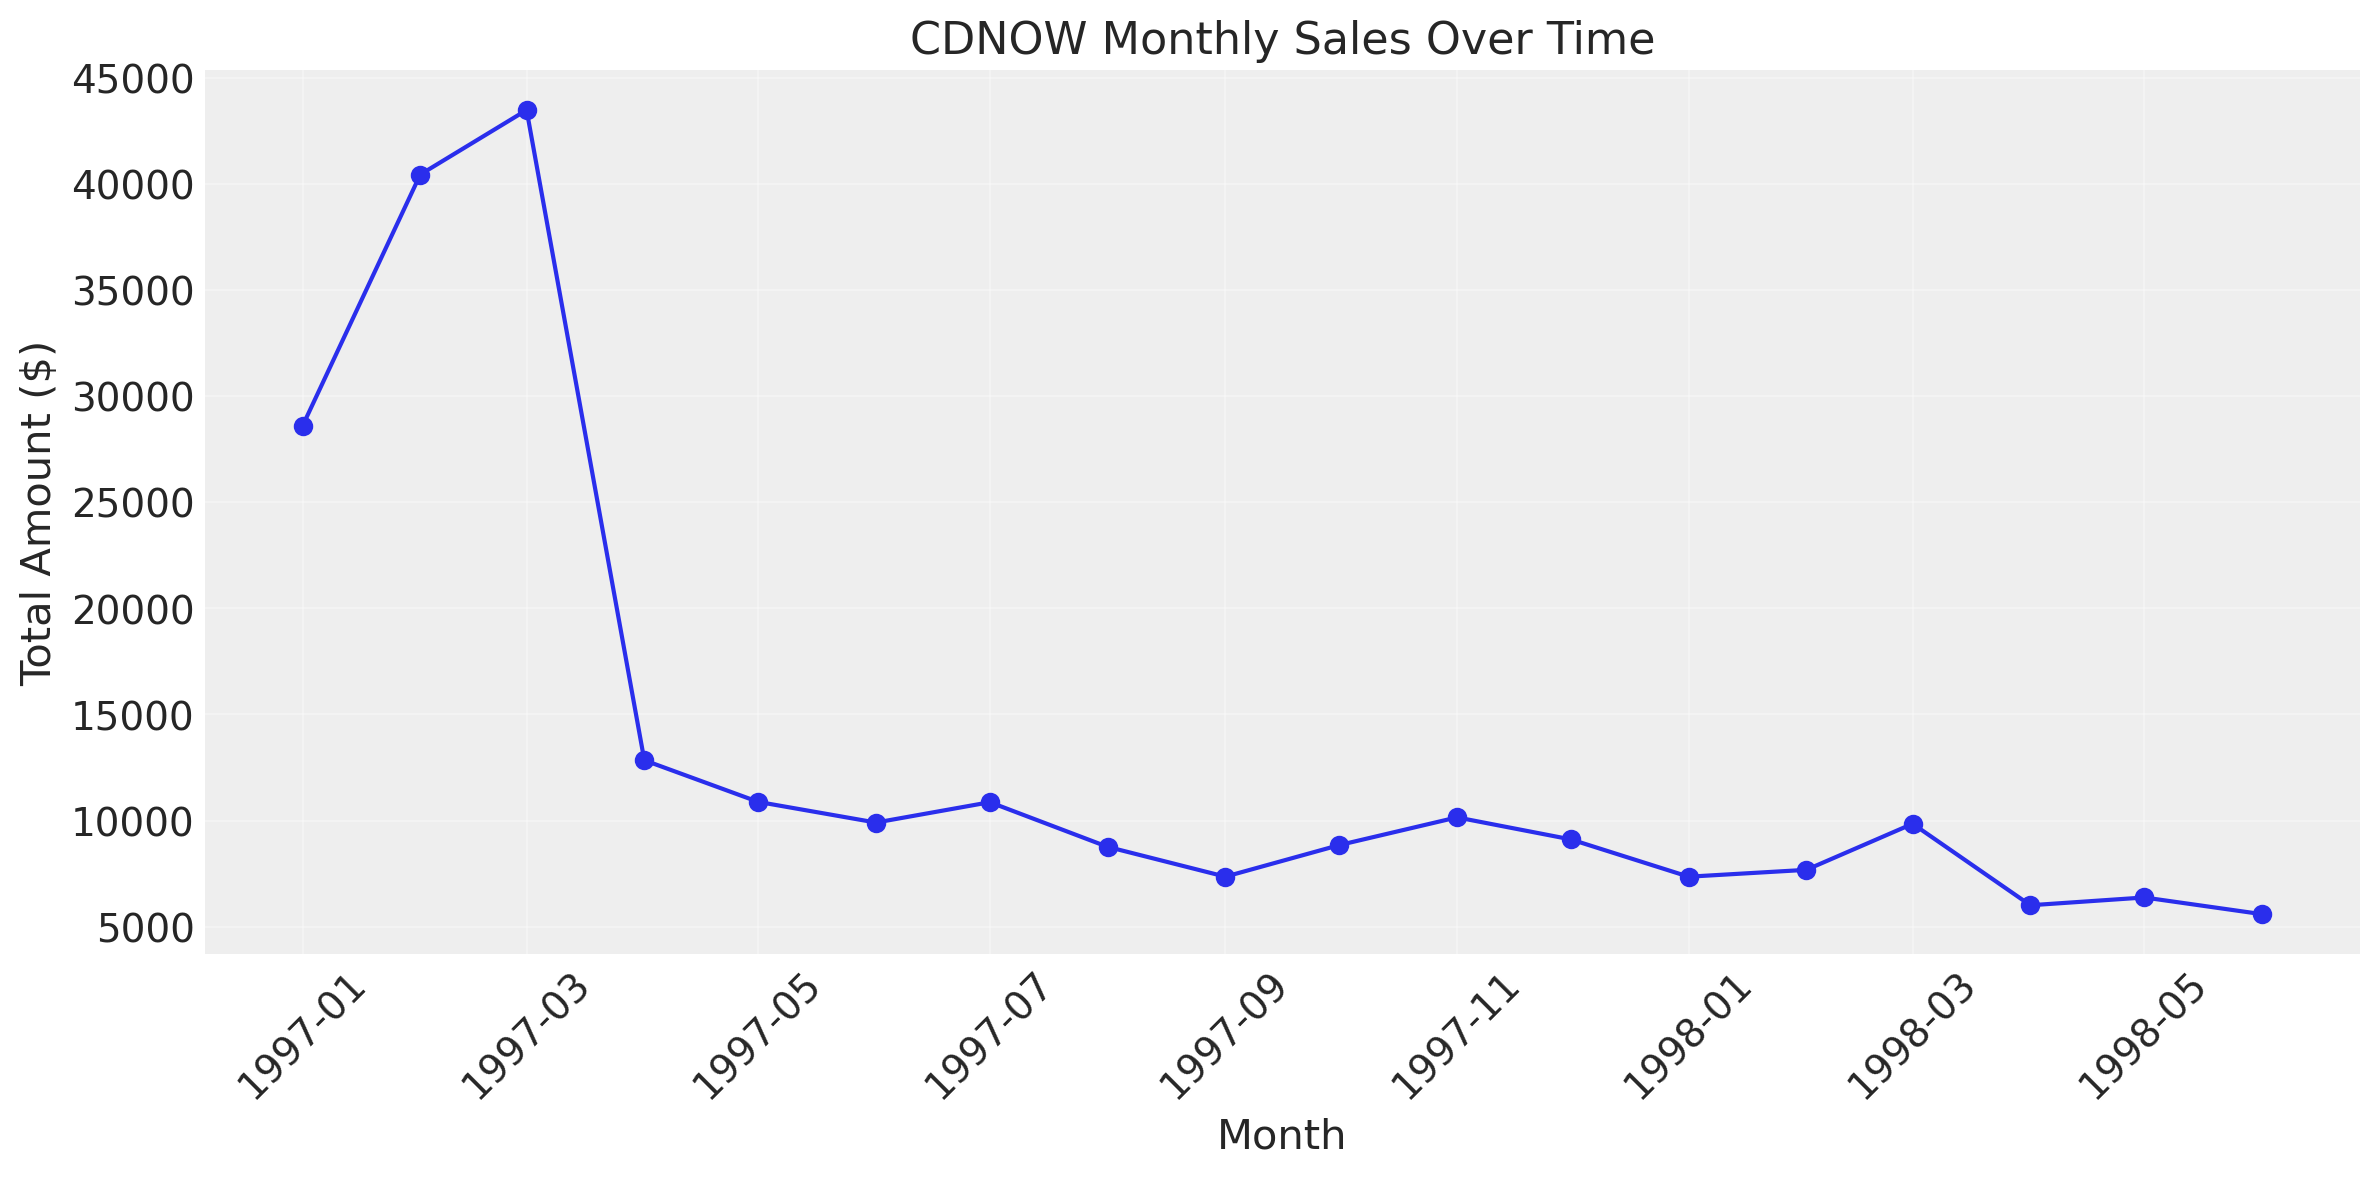

In [7]:
# Monthly aggregation
df["year_month"] = df["date"].dt.to_period("M")
monthly_sales = df.groupby("year_month")["spent"].sum().reset_index()
monthly_sales["year_month"] = monthly_sales["year_month"].dt.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales["year_month"], monthly_sales["spent"], marker="o")
plt.xlabel("Month")
plt.ylabel("Total Amount ($)")
plt.title("CDNOW Monthly Sales Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
cdnow_ggm = cdnow_rfm.query("frequency>0").copy()
ggm = clv.GammaGammaModel(
    data=cdnow_ggm,
    model_config={
        "p": Prior("Weibull", alpha=2, beta=1),
        "q": Prior("Weibull", alpha=2, beta=1),
        "v": Prior("Weibull", alpha=2, beta=10),
    },
)
ggm.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

In [18]:
cdnow_rfm = cdnow_rfm.merge(cdnow_segments[["customer_id", "segment"]]).copy()
cdnow_segments["pred_spend"] = (
    ggm.expected_customer_spend(cdnow_rfm).mean(("chain", "draw")).values
)

In [19]:
violion_plot_df = pd.melt(
    cdnow_segments,
    id_vars=["customer_id", "segment"],
    value_vars=["monetary_value", "pred_spend"],
)

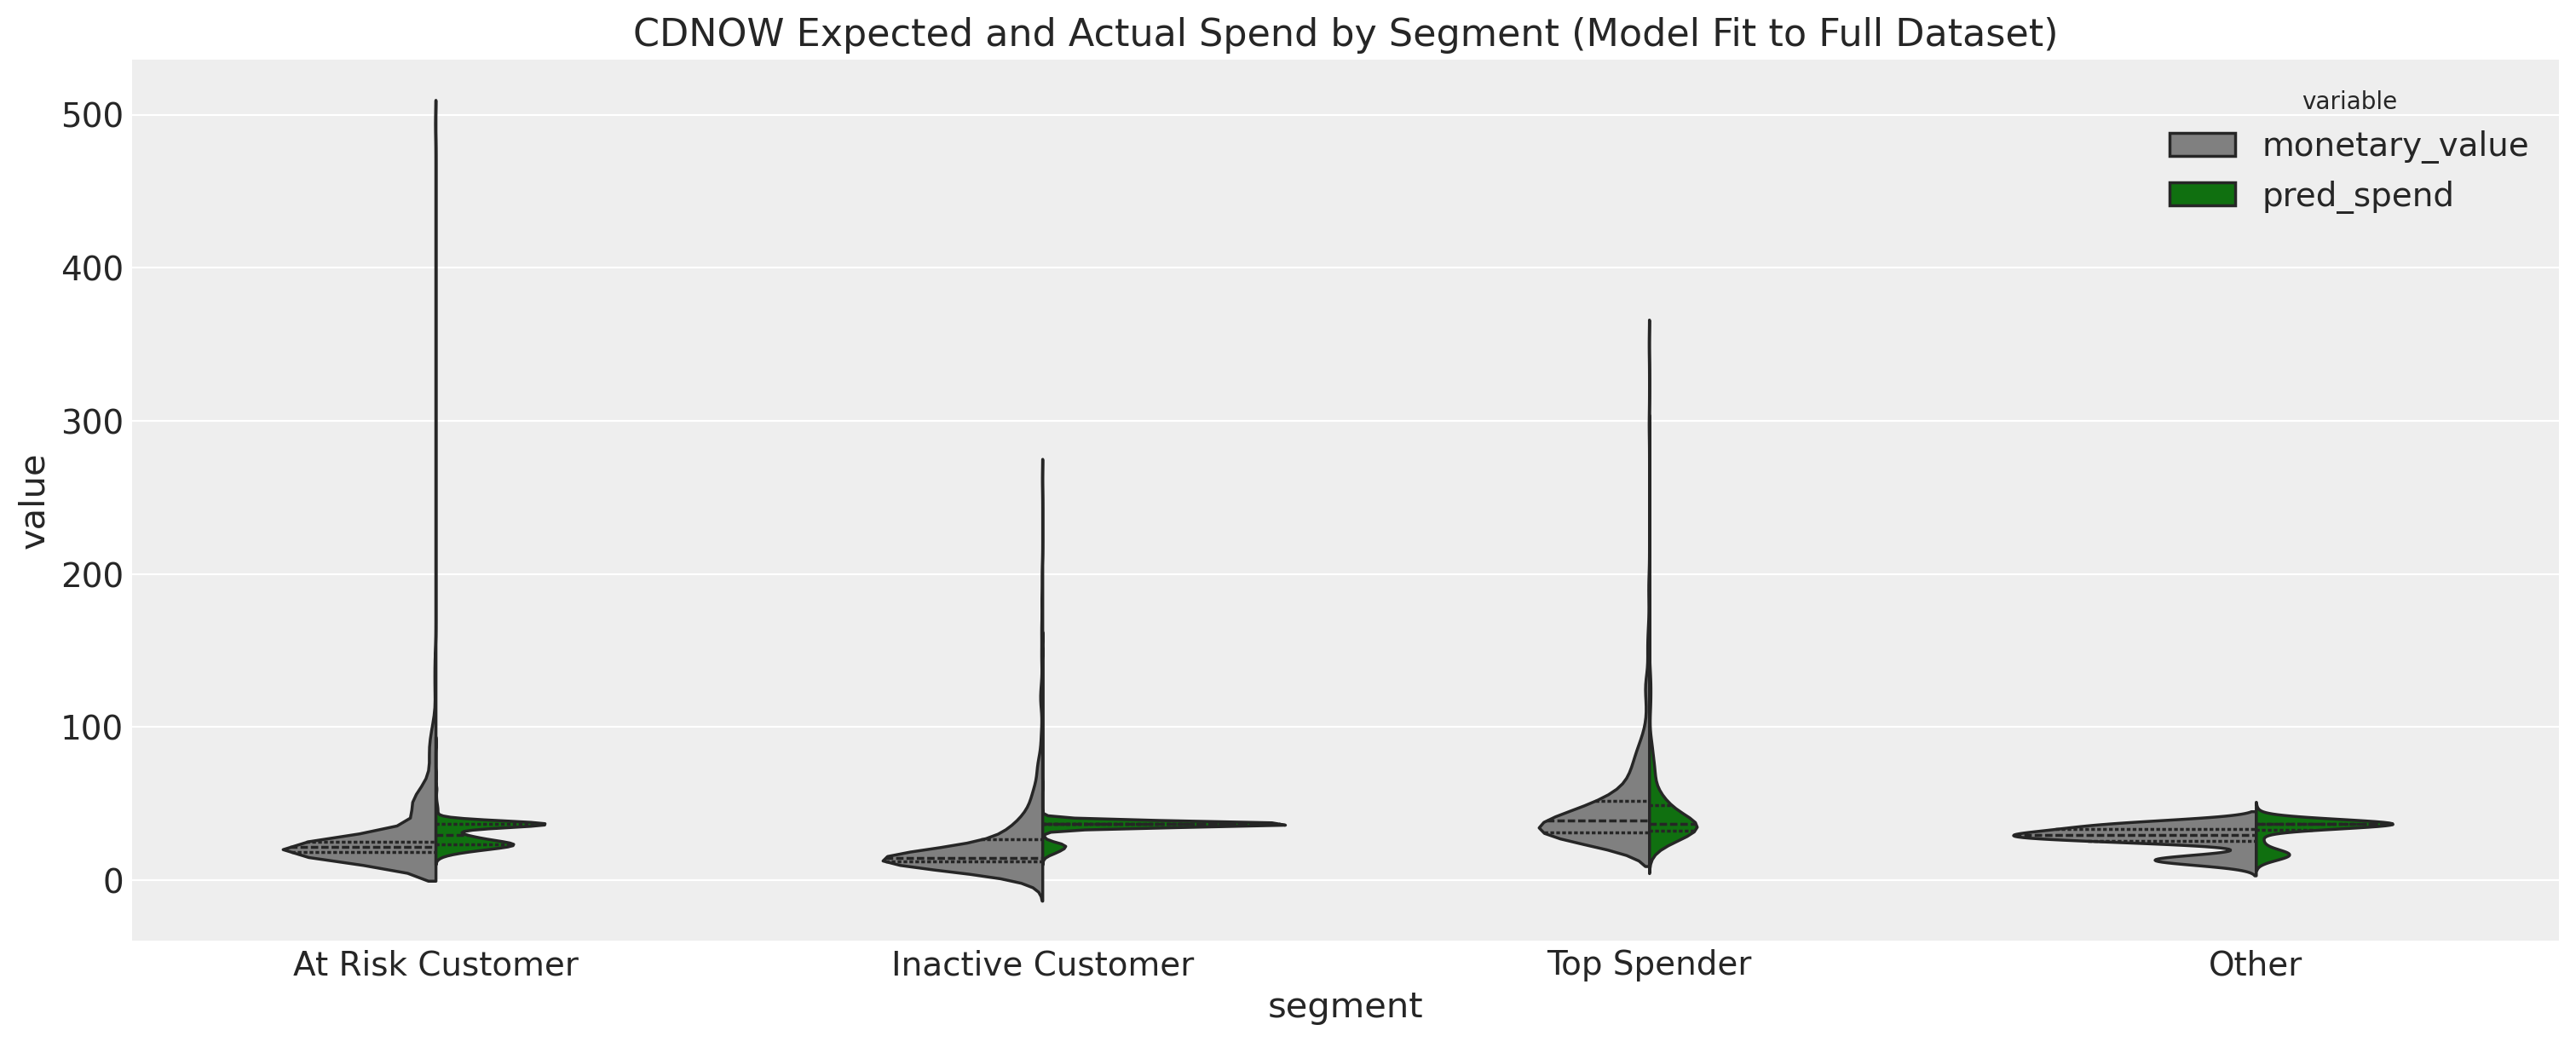

In [20]:
# Create a Matplotlib figure and axes with a specified size (width, height in inches)
fig, ax = plt.subplots(figsize=(15, 6))

trunc_plot_df = violion_plot_df[violion_plot_df["value"] < 500].copy()

ax.set_title("CDNOW Expected and Actual Spend by Segment (Model Fit to Full Dataset)")

sb.violinplot(
    data=trunc_plot_df,
    x="segment",
    y="value",
    hue="variable",
    split=True,
    inner="quart",
    fill=True,
    palette={"pred_spend": "g", "monetary_value": ".5"},
    ax=ax,
)
plt.show()

In [13]:
cdnow_inactive = cdnow_rfm[cdnow_rfm["segment"] == "Inactive Customer"]
cdnow_inactive

,customer_id,frequency,recency,T,monetary_value,segment,pred_spend
1,2,1.0,12.0,545.0,11.77,Inactive Customer,22.041628
2,3,0.0,0.0,545.0,0.00,Inactive Customer,36.862837
3,4,0.0,0.0,545.0,0.00,Inactive Customer,36.862837
4,5,0.0,0.0,545.0,0.00,Inactive Customer,36.862837
6,7,1.0,35.0,545.0,11.77,Inactive Customer,22.041628
...,...,...,...,...,...,...,...
2340,2341,0.0,0.0,462.0,0.00,Inactive Customer,36.862837
2344,2345,0.0,0.0,462.0,0.00,Inactive Customer,36.862837
2348,2349,1.0,65.0,462.0,13.97,Inactive Customer,23.340480
2350,2351,0.0,0.0,462.0,0.00,Inactive Customer,36.862837


In [15]:
inactive_ggm = cdnow_inactive.query("frequency>0").copy()
ggm_inactive = clv.GammaGammaModel(
    data=inactive_ggm,
    model_config={
        "p": Prior("Weibull", alpha=2, beta=1),
        "q": Prior("Weibull", alpha=2, beta=1),
        "v": Prior("Weibull", alpha=2, beta=10),
    },
)
ggm_inactive.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

In [23]:
inactive_segment = cdnow_segments[
    cdnow_segments["segment"] == "Inactive Customer"
].copy()
inactive_segment["pred_spend"] = (
    ggm_inactive.expected_customer_spend(cdnow_inactive).mean(("chain", "draw")).values
)
violin_inactive = pd.melt(
    inactive_segment,
    id_vars=["customer_id", "segment"],
    value_vars=["monetary_value", "pred_spend"],
)

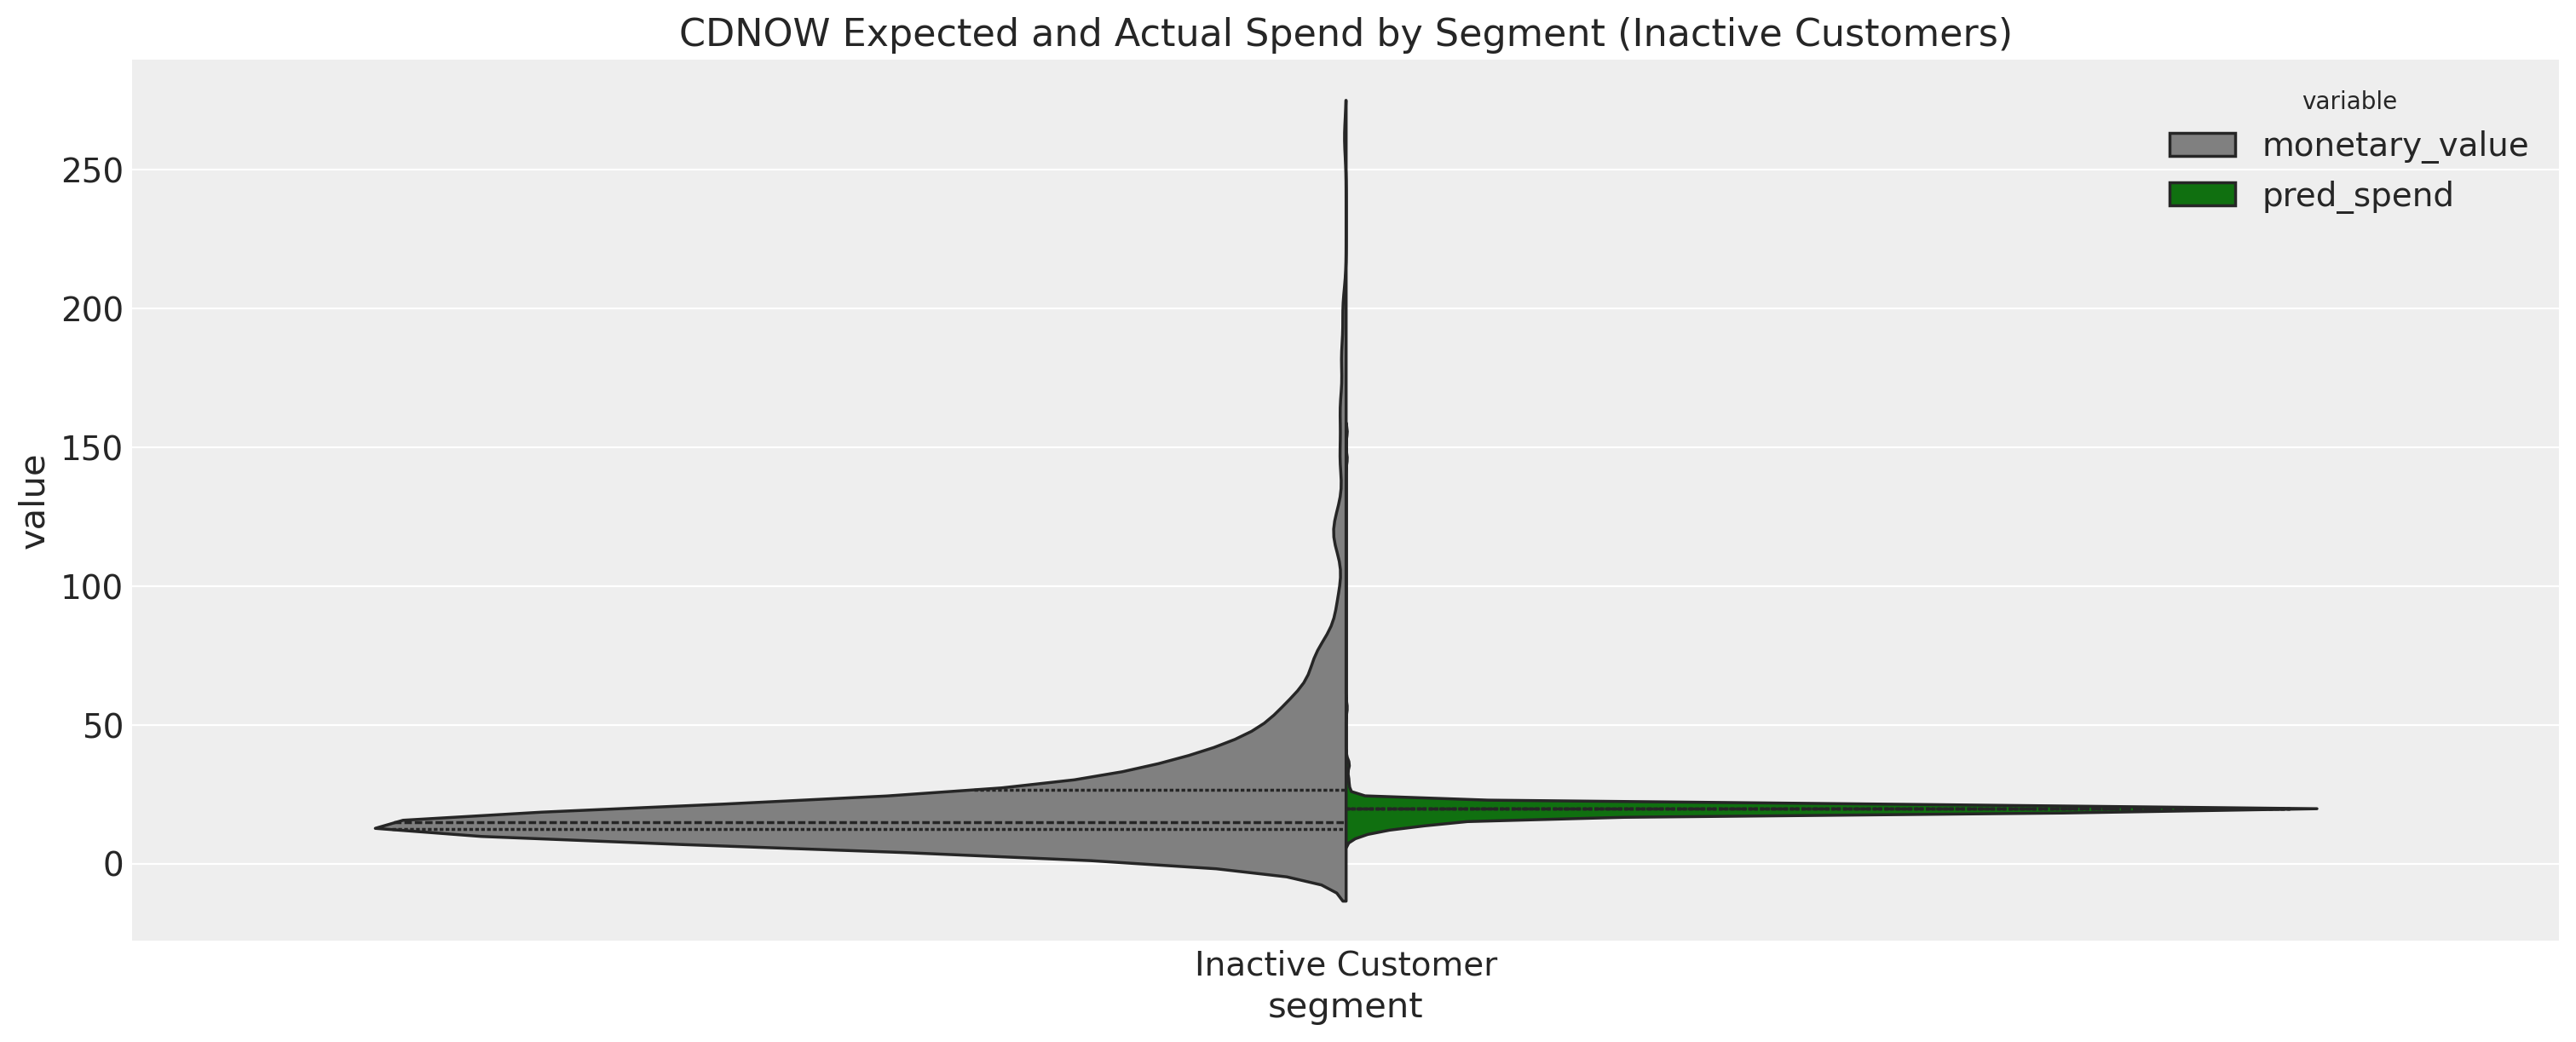

In [24]:
# Create a Matplotlib figure and axes with a specified size (width, height in inches)
fig, ax = plt.subplots(figsize=(15, 6))

trunc_inactive = violin_inactive[violin_inactive["value"] < 500].copy()

ax.set_title("CDNOW Expected and Actual Spend by Segment (Inactive Customers)")

sb.violinplot(
    data=trunc_inactive,
    x="segment",
    y="value",
    hue="variable",
    split=True,
    inner="quart",
    fill=True,
    palette={"pred_spend": "g", "monetary_value": ".5"},
    ax=ax,
)
plt.show()